Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import json
from geopy.geocoders import Nominatim
import geocoder
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import json_normalize
from sklearn.metrics import silhouette_score
from bs4 import BeautifulSoup as bs

%matplotlib notebook

print('All libraries imported.')

All libraries imported.


Read Data For London Boroughs 

In [2]:
URL = "https://en.wikipedia.org/wiki/List_of_areas_of_London"
res = requests.get(URL).text
soup = bs(res,'lxml')

df_list = []
# print(soup)
for items in soup.find('table', class_= 'wikitable sortable').find_all('tr')[1::]:
    data = items.find_all(['td'])
    data1 = data[0]#location
    data2 = data[1]#borough
    data3 = data[5]#coordinations
    
    try:
        #save location name
        location_name = data1.get_text()
        location_name = location_name.split('[')
        location_name = location_name[0]
        location_name = location_name.strip()
        
        #save borough name
        borough_name = data2.get_text()
        borough_name = borough_name.split('[')
        borough_name = borough_name[0]
        borough_name = borough_name.strip()
        
        #save latitude and longitude
        ll = data3.span
        ll = str(ll)
        ll = ll.split(';')
        ll = ll[1].split('=')
        ll = ll[1].split('_')
        latitude = ll[0]
        longitude = ll[2]

#       Append the borough name, latitude and logitude in a list
        df_list.append((location_name, borough_name, latitude, longitude))
    except IndexError:pass
    
df_boroughs = pd.DataFrame(df_list, columns=['Location', 'Borough', 'Latitude' , 'Longitude'])

df_boroughs.head(10)

,Location,Borough,Latitude,Longitude
0,Abbey Wood,"Bexley, Greenwich",51.48648031512,0.10859224316653
1,Acton,"Ealing, Hammersmith and Fulham",51.51058775877,0.26498902668911
2,Addington,Croydon,51.362931128458,0.026373738779412
3,Addiscombe,Croydon,51.381621885559,0.068682165650808
4,Albany Park,Bexley,51.434925966837,0.12492137518833
5,Aldborough Hatch,Redbridge,51.585577492045,0.098742119839992
6,Aldgate,City,51.51488143102,0.078904677469267
7,Aldwych,Westminster,51.512815974418,0.11790391775668
8,Alperton,Brent,51.537972630034,0.29278706020275
9,Anerley,Bromley,51.408581417837,0.067546374056709


In [3]:
df_boroughs['Borough'].value_counts()

Barnet                                            34
Bromley                                           34
Bexley                                            25
Croydon                                           22
Havering                                          21
Tower Hamlets                                     21
Westminster                                       19
Richmond upon Thames                              19
Hackney                                           18
Lewisham                                          18
Camden                                            17
Hillingdon                                        17
Enfield                                           17
Brent                                             16
Haringey                                          15
Newham                                            14
Hounslow                                          14
Kingston upon Thames                              13
Islington                                     

We can see that there are many locations that appear only once. This is because the main locations are being further divided. So we clean the Boroughs name to make it easier to understand.

In [4]:
df_boroughs['Borough'] = df_boroughs['Borough'].apply(lambda x: x.split(',')[0])
df_boroughs.head(10)

,Location,Borough,Latitude,Longitude
0,Abbey Wood,Bexley,51.48648031512,0.10859224316653
1,Acton,Ealing,51.51058775877,0.26498902668911
2,Addington,Croydon,51.362931128458,0.026373738779412
3,Addiscombe,Croydon,51.381621885559,0.068682165650808
4,Albany Park,Bexley,51.434925966837,0.12492137518833
5,Aldborough Hatch,Redbridge,51.585577492045,0.098742119839992
6,Aldgate,City,51.51488143102,0.078904677469267
7,Aldwych,Westminster,51.512815974418,0.11790391775668
8,Alperton,Brent,51.537972630034,0.29278706020275
9,Anerley,Bromley,51.408581417837,0.067546374056709


In [5]:
df_boroughs['Borough'].value_counts()

Barnet                    36
Bromley                   34
Bexley                    30
Croydon                   22
Havering                  21
Tower Hamlets             21
Lewisham                  20
Brent                     20
Westminster               19
Richmond upon Thames      19
Hackney                   18
Camden                    18
Haringey                  17
Enfield                   17
Hillingdon                17
Redbridge                 16
Hounslow                  15
Islington                 15
Newham                    14
Greenwich                 14
Southwark                 13
Harrow                    13
Kingston upon Thames      13
Lambeth                   12
Wandsworth                10
Merton                    10
Ealing                    10
Kensington and Chelsea     9
Hammersmith and Fulham     9
Barking and Dagenham       8
Waltham Forest             8
Sutton                     7
City                       4
Name: Borough, dtype: int64

In [6]:
df_boroughs

,Location,Borough,Latitude,Longitude
0,Abbey Wood,Bexley,51.48648031512,0.10859224316653
1,Acton,Ealing,51.51058775877,0.26498902668911
2,Addington,Croydon,51.362931128458,0.026373738779412
3,Addiscombe,Croydon,51.381621885559,0.068682165650808
4,Albany Park,Bexley,51.434925966837,0.12492137518833
...,...,...,...,...
524,Woolwich,Greenwich,51.496234488147,0.065821080670888
525,Worcester Park,Sutton,51.375348602793,0.2413698232129
526,Wormwood Scrubs,Hammersmith and Fulham,51.51914529563,0.2358364367502
527,Yeading,Hillingdon,51.530409425123,0.39398974116165


Data Visualization

In [7]:
neighborhoods_london = df_boroughs.groupby('Borough')['Location'].nunique()
neighborhoods_london

Borough
Barking and Dagenham       8
Barnet                    36
Bexley                    30
Brent                     20
Bromley                   34
Camden                    18
City                       4
Croydon                   22
Ealing                    10
Enfield                   17
Greenwich                 14
Hackney                   18
Hammersmith and Fulham     9
Haringey                  17
Harrow                    13
Havering                  21
Hillingdon                17
Hounslow                  15
Islington                 15
Kensington and Chelsea     9
Kingston upon Thames      13
Lambeth                   12
Lewisham                  20
Merton                    10
Newham                    14
Redbridge                 16
Richmond upon Thames      19
Southwark                 13
Sutton                     7
Tower Hamlets             21
Waltham Forest             8
Wandsworth                10
Westminster               19
Name: Location, dtype: int64

<IPython.core.display.Javascript object>


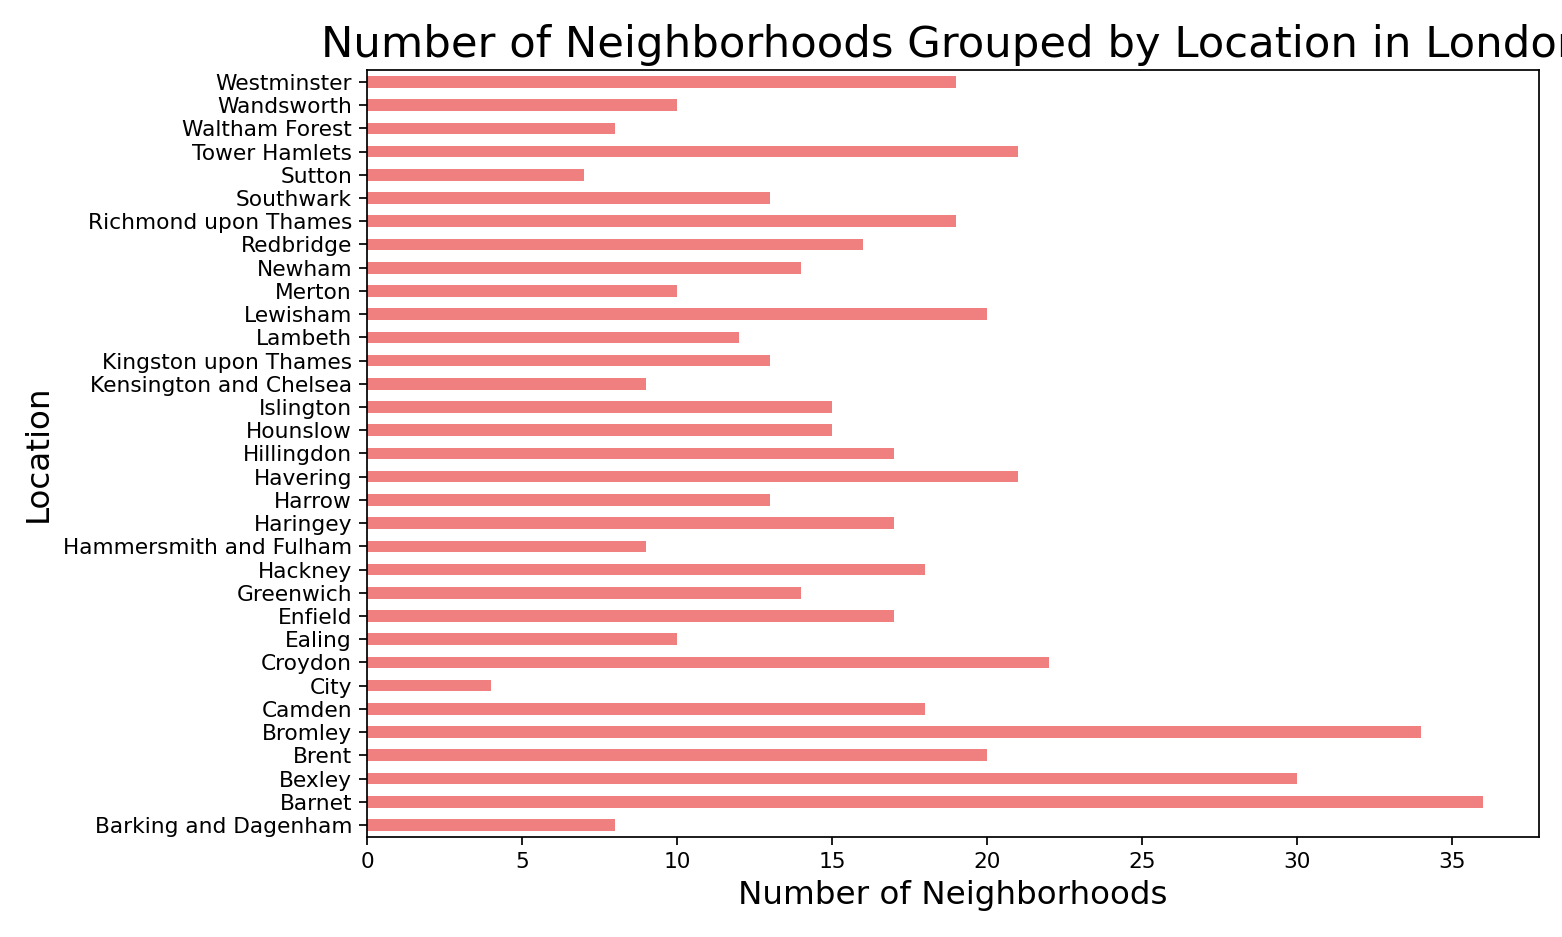

In [8]:
fig = plt.figure(figsize=(10,6))

ax = neighborhoods_london.plot(kind='barh', color='lightcoral')
ax.set_title('Number of Neighborhoods Grouped by Location in London', fontsize=20)
ax.set_xlabel('Number of Neighborhoods', fontsize=15)
ax.set_ylabel('Location', fontsize=15)

fig.tight_layout()

We can concluded that Barnet, Bexley and Bromley have the most number of Neighborhoods.

In [9]:

address = 'London, UK'
geolocator = Nominatim(user_agent="explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of London are 51.5073219, -0.1276474.


In [10]:
map_mum = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, location, neighborhood in zip(df_boroughs['Latitude'], df_boroughs['Longitude'], df_boroughs['Borough'], df_boroughs['Location']):
    label = '{}, {}'.format(neighborhood, location)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mum)  
    
map_mum

In [ ]:
CLIENT_ID = '*****************************' # your Foursquare ID
CLIENT_SECRET = '*****************************' # your Foursquare Secret
VERSION = '********' # Foursquare API version
LIMIT = 200 # A default Foursquare API limit value

In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [13]:
mum_venues = getNearbyVenues(names=df_boroughs['Location'], latitudes=df_boroughs['Latitude'], longitudes=df_boroughs['Longitude'], radius=1000)

Abbey Wood
Acton
Addington
Addiscombe
Albany Park
Aldborough Hatch
Aldgate
Aldwych
Alperton
Anerley
Angel
Aperfield
Archway
Ardleigh Green
Arkley
Arnos Grove
Balham
Bankside
Barbican
Barking
Barkingside
Barnehurst
Barnes
Barnes Cray
Barnet Gate
Barnet (also Chipping Barnet, High Barnet)
Barnsbury
Battersea
Bayswater
Beckenham
Beckton
Becontree
Becontree Heath
Beddington
Bedford Park
Belgravia
Bellingham
Belmont
Belmont
Belsize Park
Belvedere
Bermondsey
Berrylands
Bethnal Green
Bexley (also Old Bexley, Bexley Village)
Bexleyheath (also Bexley New Town)
Bickley
Biggin Hill
Blackfen
Blackfriars
Blackheath
Blackheath Royal Standard
Blackwall
Bloomsbury
Botany Bay
Bounds Green
Bow
Bowes Park
Brentford
Brent Cross
Brent Park
Brimsdown
Brixton
Brockley
Bromley
Bromley (also Bromley-by-Bow)
Bromley Common
Brompton
Brondesbury
Brunswick Park
Bulls Cross
Burnt Oak
Burroughs, The
Camberwell
Cambridge Heath
Camden Town
Canary Wharf
Cann Hall
Canning Town
Canonbury
Carshalton
Castelnau
Castle Green

In [14]:
mum_venues.groupby('Neighborhood', as_index=False).count()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Abbey Wood,9,9,9,9,9,9
1,Acton,5,5,5,5,5,5
2,Addington,6,6,6,6,6,6
3,Addiscombe,12,12,12,12,12,12
4,Albany Park,5,5,5,5,5,5
...,...,...,...,...,...,...,...
507,Woodside Park,4,4,4,4,4,4
508,Woolwich,61,61,61,61,61,61
509,Wormwood Scrubs,1,1,1,1,1,1
510,Yeading,3,3,3,3,3,3


In [15]:
print("There are {} unique categories".format(mum_venues['Venue Category'].nunique()))

There are 291 unique categories


Analyzing each neighborhood

In [16]:
categories_onehot = pd.get_dummies(mum_venues[['Venue Category']], prefix="", prefix_sep="")
categories_onehot.head(10)

,Accessories Store,African Restaurant,Airfield,Airport,Airport Lounge,Airport Service,Airport Terminal,Airport Ticket Counter,American Restaurant,Argentinian Restaurant,...,Warehouse Store,Waste Facility,Waterfront,Wedding Hall,Weight Loss Center,Windmill,Wine Bar,Wine Shop,Zoo,Zoo Exhibit
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
categories_onehot['Neighborhood'] = mum_venues['Neighborhood']
categories_onehot.head()

#Moving neighborhood name in the front

temp = list(categories_onehot.columns)

if 'Neighborhood' in temp:
    temp.remove('Neighborhood')
    
fixed_columns = ['Neighborhood'] + temp
categories_onehot = categories_onehot[fixed_columns]

categories_onehot.head()

#categorise the neighborhood to take the mean value 

categories_grouped = categories_onehot.groupby('Neighborhood', sort=False).mean().reset_index()
print(categories_grouped.shape)
categories_grouped.head(10)

(512, 292)


,Neighborhood,Accessories Store,African Restaurant,Airfield,Airport,Airport Lounge,Airport Service,Airport Terminal,Airport Ticket Counter,American Restaurant,...,Warehouse Store,Waste Facility,Waterfront,Wedding Hall,Weight Loss Center,Windmill,Wine Bar,Wine Shop,Zoo,Zoo Exhibit
0,Abbey Wood,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Acton,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Addington,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Addiscombe,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Albany Park,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Aldborough Hatch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Aldgate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Aldwych,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Alperton,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Anerley,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
num_top_venues = 5

for hood in categories_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = categories_grouped[categories_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Abbey Wood----
               venue  freq
0      Grocery Store  0.11
1        Coffee Shop  0.11
2  Indian Restaurant  0.11
3             Forest  0.11
4     Hardware Store  0.11


----Acton----
         venue  freq
0  Golf Course   0.2
1        Field   0.2
2         Lake   0.2
3   Restaurant   0.2
4          Gym   0.2


----Addington----
                        venue  freq
0                         Pub  0.33
1               Event Service  0.17
2                    Boutique  0.17
3  Construction & Landscaping  0.17
4                        Lake  0.17


----Addiscombe----
                      venue  freq
0                       Pub  0.17
1  Mediterranean Restaurant  0.17
2                      Park  0.08
3               Supermarket  0.08
4          Sushi Restaurant  0.08


----Albany Park----
           venue  freq
0  Train Station   0.2
1         Forest   0.2
2  Grocery Store   0.2
3           Park   0.2
4    Golf Course   0.2


----Aldborough Hatch----
               venue  freq
0 

Lets now create a dataframe with the top 10 common venues for each neighborhood

In [19]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [20]:
top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = categories_grouped['Neighborhood']

for ind in np.arange(categories_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(categories_grouped.iloc[ind, :], top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abbey Wood,Forest,Hardware Store,Campground,Platform,Indian Restaurant,Café,Grocery Store,Soccer Field,Coffee Shop,Factory
1,Acton,Field,Gym,Lake,Restaurant,Golf Course,Fast Food Restaurant,Exhibit,Fabric Shop,Factory,Farm
2,Addington,Pub,Event Service,Construction & Landscaping,Boutique,Lake,Financial or Legal Service,Factory,Farm,Farmers Market,Fast Food Restaurant
3,Addiscombe,Mediterranean Restaurant,Pub,Park,Fish & Chips Shop,Supermarket,Sushi Restaurant,Thai Restaurant,Turkish Restaurant,Gym,Train Station
4,Albany Park,Forest,Train Station,Grocery Store,Park,Golf Course,Flower Shop,Flea Market,Fish & Chips Shop,Financial or Legal Service,Field
...,...,...,...,...,...,...,...,...,...,...,...
507,Woodside Park,Electronics Store,Park,Restaurant,Pub,Food Court,Fast Food Restaurant,Exhibit,Fabric Shop,Factory,Farm
508,Woolwich,Pub,Grocery Store,Coffee Shop,Clothing Store,Fast Food Restaurant,Pier,Gym / Fitness Center,Plaza,Bakery,Hotel
509,Wormwood Scrubs,Clothing Store,Zoo Exhibit,Event Space,Fabric Shop,Factory,Farm,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service
510,Yeading,Construction & Landscaping,Pet Store,Business Service,Zoo Exhibit,Financial or Legal Service,Factory,Farm,Farmers Market,Fast Food Restaurant,Field


Clustering Neighborhoods

<IPython.core.display.Javascript object>


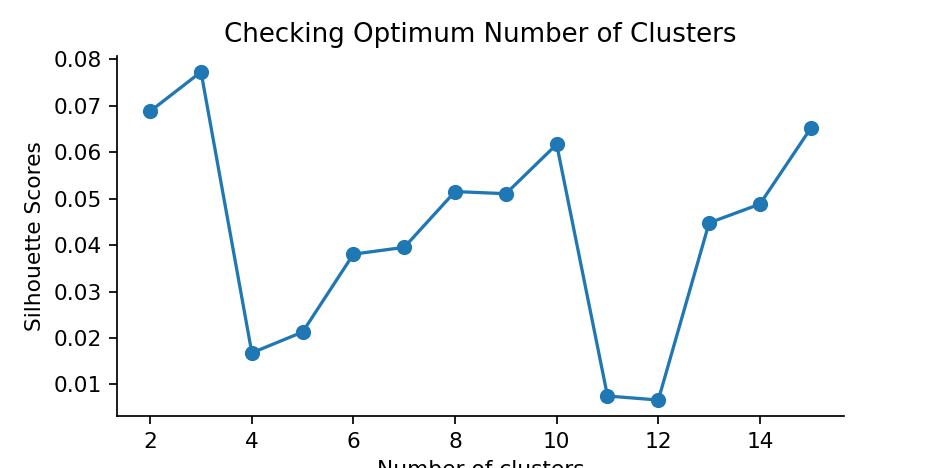

In [21]:
maxk = 15
scores = []
kval = []

categories_grouped_1 = categories_grouped 

for k in range(2, maxk+1):
    cl_df = categories_grouped.drop('Neighborhood', axis=1)
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=40).fit_predict(cl_df) #Choose any random_state
    
    score = silhouette_score(cl_df, kmeans, metric='euclidean', random_state=0)
    kval.append(k)
    scores.append(score)
    
#plot the values of the KMeans
fig = plt.figure(figsize=(6,3))
plt.plot(kval, scores, 'o-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Scores')
plt.title('Checking Optimum Number of Clusters')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [27]:
k = 3#the best k for cluster

mum_clustering = categories_grouped_1.drop('Neighborhood', axis=1)
kmeans_1 = KMeans(n_clusters=k, init="k-means++", random_state=40).fit(mum_clustering) #Can choose any random_state

kmeans_1.labels_

#neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans_1.labels_)
mum_merged = df_boroughs
mum_merged = mum_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Location')

Cluster 1

In [30]:
mum_merged.loc[mum_merged['Cluster Labels'] == 0, mum_merged.columns[[0] + [1] + list(range(5, mum_merged.shape[1]))]]

,Location,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abbey Wood,Bexley,Forest,Hardware Store,Campground,Platform,Indian Restaurant,Café,Grocery Store,Soccer Field,Coffee Shop,Factory
1,Acton,Ealing,Field,Gym,Lake,Restaurant,Golf Course,Fast Food Restaurant,Exhibit,Fabric Shop,Factory,Farm
4,Albany Park,Bexley,Forest,Train Station,Grocery Store,Park,Golf Course,Flower Shop,Flea Market,Fish & Chips Shop,Financial or Legal Service,Field
5,Aldborough Hatch,Redbridge,Sporting Goods Shop,Social Club,Steakhouse,Supermarket,Indian Restaurant,Metro Station,Soccer Field,Café,Field,Fabric Shop
6,Aldgate,City,Clothing Store,Pizza Place,Pharmacy,Supermarket,Coffee Shop,Furniture / Home Store,Sporting Goods Shop,Portuguese Restaurant,Gastropub,Pet Store
...,...,...,...,...,...,...,...,...,...,...,...,...
521,Woodlands,Hounslow,Boat or Ferry,Church,Port,Supermarket,Beach,Fast Food Restaurant,Zoo Exhibit,Factory,Farm,Farmers Market
522,Woodside,Croydon,Supermarket,Pub,American Restaurant,Mexican Restaurant,Thai Restaurant,Mediterranean Restaurant,Sushi Restaurant,Turkish Restaurant,Indian Restaurant,Park
524,Woolwich,Greenwich,Pub,Grocery Store,Coffee Shop,Clothing Store,Fast Food Restaurant,Pier,Gym / Fitness Center,Plaza,Bakery,Hotel
526,Wormwood Scrubs,Hammersmith and Fulham,Clothing Store,Zoo Exhibit,Event Space,Fabric Shop,Factory,Farm,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service


Cluster 2

In [31]:
mum_merged.loc[mum_merged['Cluster Labels'] == 1, mum_merged.columns[[0] + [1] + list(range(5, mum_merged.shape[1]))]]

,Location,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
80,Carshalton,Sutton,Golf Course,Tree,Event Space,Fabric Shop,Factory,Farm,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service
89,Cheam,Sutton,Golf Course,Zoo Exhibit,Forest,Fabric Shop,Factory,Farm,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service
334,North Ockendon,Havering,Pub,Golf Course,Event Space,Fabric Shop,Factory,Farm,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service
378,Rayners Lane,Harrow,Golf Course,Zoo Exhibit,Forest,Fabric Shop,Factory,Farm,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service
464,Totteridge,Barnet,Golf Course,Campground,Exhibit,Fabric Shop,Factory,Farm,Farmers Market,Fast Food Restaurant,Field,Zoo Exhibit
489,Wealdstone,Harrow,Golf Course,Zoo Exhibit,Forest,Fabric Shop,Factory,Farm,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service


Cluster 3

In [32]:
mum_merged.loc[mum_merged['Cluster Labels'] == 2, mum_merged.columns[[0] + [1] + list(range(5, mum_merged.shape[1]))]]

,Location,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Addington,Croydon,Pub,Event Service,Construction & Landscaping,Boutique,Lake,Financial or Legal Service,Factory,Farm,Farmers Market,Fast Food Restaurant
3,Addiscombe,Croydon,Mediterranean Restaurant,Pub,Park,Fish & Chips Shop,Supermarket,Sushi Restaurant,Thai Restaurant,Turkish Restaurant,Gym,Train Station
8,Alperton,Brent,Pub,Racetrack,Golf Course,Zoo Exhibit,Fast Food Restaurant,Event Space,Exhibit,Fabric Shop,Factory,Farm
9,Anerley,Bromley,Pub,Italian Restaurant,Platform,Gastropub,Café,Cave,Train Station,Indian Restaurant,Cricket Ground,Seafood Restaurant
10,Angel,Islington,Mediterranean Restaurant,Pub,Park,Fish & Chips Shop,Supermarket,Sushi Restaurant,Thai Restaurant,Turkish Restaurant,Gym,Train Station
...,...,...,...,...,...,...,...,...,...,...,...,...
510,Whetstone,Barnet,Pub,Electronics Store,Construction & Landscaping,Zoo Exhibit,Financial or Legal Service,Fabric Shop,Factory,Farm,Farmers Market,Fast Food Restaurant
511,White City,Hammersmith and Fulham,Hotel,Home Service,Restaurant,Golf Course,Pub,Food & Drink Shop,Farmers Market,Event Service,Event Space,Exhibit
515,Willesden,Brent,Cosmetics Shop,Photography Studio,Home Service,Pub,Construction & Landscaping,Record Shop,Nature Preserve,Exhibit,Fabric Shop,Factory
523,Woodside Park,Barnet,Electronics Store,Park,Restaurant,Pub,Food Court,Fast Food Restaurant,Exhibit,Fabric Shop,Factory,Farm


Result

In [36]:
new_cafe_neighborhoods = mum_merged.loc[mum_merged['Cluster Labels'] == 0, mum_merged.columns[[0, 1, 2, 3] + list(range(5, mum_merged.shape[1]))]]
new_cafe_neighborhoods.head()

#map
map_res_locations = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, location, neighborhood in zip(new_cafe_neighborhoods['Latitude'], new_cafe_neighborhoods['Longitude'],
                                            new_cafe_neighborhoods['Location'], new_cafe_neighborhoods['Location']):
    label = '{}, {}'.format(neighborhood, location)
    folium.Marker([lat, lng], popup='{} has geographical coordinates ({:.4s}, {:.4s})'.format(label, lat, lng),
                  icon=folium.Icon(color='lightred'), tooltip=label).add_to(map_res_locations)
    
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_res_locations) 

map_res_locations